In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np

2024-07-14 17:22:23.319036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 17:22:23.366261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 17:22:23.366574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 17:22:23.427310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 17:22:24.093367: W tensorflow/compiler/tf

In [2]:
# First get our data for csv.
df = pd.read_csv('BTCUSDT.csv')

In [3]:
# Gets all of our averages.

def get_averages(data):

    # only take close and open and time
    data = data[['Close', 'Open', 'Open time']]

    # data['MA5'] = data['Close'].rolling(window=5).mean()

    # data['MA20'] = data['Close'].rolling(window=20).mean()

    # data['MA60'] = data['Close'].rolling(window=60).mean()

    # data['MA720'] = data['Close'].rolling(window=720).mean()

    # data['MA1440'] = data['Close'].rolling(window=1440).mean()

    # data['MA10080'] = data['Close'].rolling(window=10080).mean()

    # data['MA131400'] = data['Close'].rolling(window=131400).mean()

    # Drop if even one of the values is na
    data = data.dropna()

    newdata = data['Open time', 'Close'].values

    return newdata


In [4]:
def normalise_averages(averages):
    
    # get max close from data
    max_close = averages[:, 0].max()
    # get min close from data
    min_close = averages[:, 0].min()

    for i in range(averages.shape[1]):
        averages[:, i] = (averages[:, i] - min_close) / (max_close - min_close)

    return averages

avg = get_averages(df)

#print (avg.shape)

#avg = normalise_averages(avg)

#print(avg)

/tmp/ipykernel_3454/1455830637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA5'] = data['Close'].rolling(window=5).mean()
/tmp/ipykernel_3454/1455830637.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA20'] = data['Close'].rolling(window=20).mean()
/tmp/ipykernel_3454/1455830637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [8]:
def create_sequences(data, seq_length, future_steps):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-future_steps):
        x = data[i:i+seq_length]
        # y is the mean over the next future_steps entries
        y = np.mean(data[i+seq_length:i+seq_length+future_steps, 0])
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 80  # Example: 50 days of past data
future_steps = 10  # Predicting the next 5 closing prices

x, y = create_sequences(avg, seq_length, future_steps)

[[1.50354720e+12 4.11358000e+03 4.11358000e+03 4.12572900e+03
  4.12091633e+03 4.11232552e+03]
 [1.50354726e+12 4.11358000e+03 4.11358000e+03 4.12540800e+03
  4.12010933e+03 4.11231085e+03]
 [1.50354732e+12 4.11358000e+03 4.11358000e+03 4.12509300e+03
  4.11986183e+03 4.11229428e+03]
 [1.50354738e+12 4.11358000e+03 4.11358000e+03 4.12509750e+03
  4.11902833e+03 4.11227961e+03]
 [1.50354744e+12 4.14753000e+03 4.12037000e+03 4.12679950e+03
  4.11933717e+03 4.11226830e+03]
 [1.50354750e+12 4.11359000e+03 4.12037200e+03 4.12680450e+03
  4.11850400e+03 4.11225363e+03]
 [1.50354756e+12 4.11359000e+03 4.12037400e+03 4.12680950e+03
  4.11825667e+03 4.11223896e+03]
 [1.50354762e+12 4.11359000e+03 4.12037600e+03 4.12592100e+03
  4.11800933e+03 4.11222429e+03]
 [1.50354768e+12 4.11359000e+03 4.12037800e+03 4.12503250e+03
  4.11800600e+03 4.11220962e+03]
 [1.50354774e+12 4.14738000e+03 4.12034800e+03 4.12583350e+03
  4.11815100e+03 4.11219830e+03]
 [1.50354780e+12 4.14819000e+03 4.12726800e+03 4.1

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,losses

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now we create a RNN model

# Create model

model = tf.Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model.add(tf.LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model.add(tf.Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(tf.LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model.add(tf.Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(tf.LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model.add(tf.Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model.add(tf.LSTM(units=50))
# 50% of the layers will be dropped
model.add(tf.Dropout(0.5))
# Dense layer that specifies an output of one unit
model.add(tf.Dense(units=1))

model.compile(optimizer='adam',
              loss=losses.MeanSquaredError(),
              metrics=[losses.MeanAbsoluteError()])


In [10]:
# More epochs
history = model.fit(x_train, y_train, epochs=15, 
                    validation_data=(x_test, y_test))

# Save the weights
history.save_weights('BTCUSDV2.h5')

Epoch 1/15


2024-07-01 22:53:17.407573: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


84235/84235 ━━━━━━━━━━━━━━━━━━━━ 656s 8ms/step - loss: 2.0493e-05 - mean_absolute_error: 0.0017 - val_loss: 3.1704e-06 - val_mean_absolute_error: 0.0023
Epoch 2/15
84235/84235 ━━━━━━━━━━━━━━━━━━━━ 632s 7ms/step - loss: 9.9342e-07 - mean_absolute_error: 8.8805e-04 - val_loss: 2.9109e-07 - val_mean_absolute_error: 5.8620e-04
Epoch 3/15
84235/84235 ━━━━━━━━━━━━━━━━━━━━ 664s 8ms/step - loss: 7.4794e-07 - mean_absolute_error: 7.7994e-04 - val_loss: 2.0580e-07 - val_mean_absolute_error: 4.2135e-04
Epoch 4/15
84235/84235 ━━━━━━━━━━━━━━━━━━━━ 661s 8ms/step - loss: 6.5343e-07 - mean_absolute_error: 7.2067e-04 - val_loss: 2.0567e-07 - val_mean_absolute_error: 4.7595e-04
Epoch 5/15
84235/84235 ━━━━━━━━━━━━━━━━━━━━ 666s 8ms/step - loss: 5.9192e-07 - mean_absolute_error: 6.8786e-04 - val_loss: 8.9843e-08 - val_mean_absolute_error: 2.4687e-04
Epoch 6/15
84235/84235 ━━━━━━━━━━━━━━━━━━━━ 668s 8ms/step - loss: 5.5275e-07 - mean_absolute_error: 6.6943e-04 - val_loss: 3.6219e-07 - val_mean_absolute_error

ValueError: The filename must end in `.weights.h5`. Received: filepath=model.h5

In [12]:
model.save_weights('model.weights.h5')

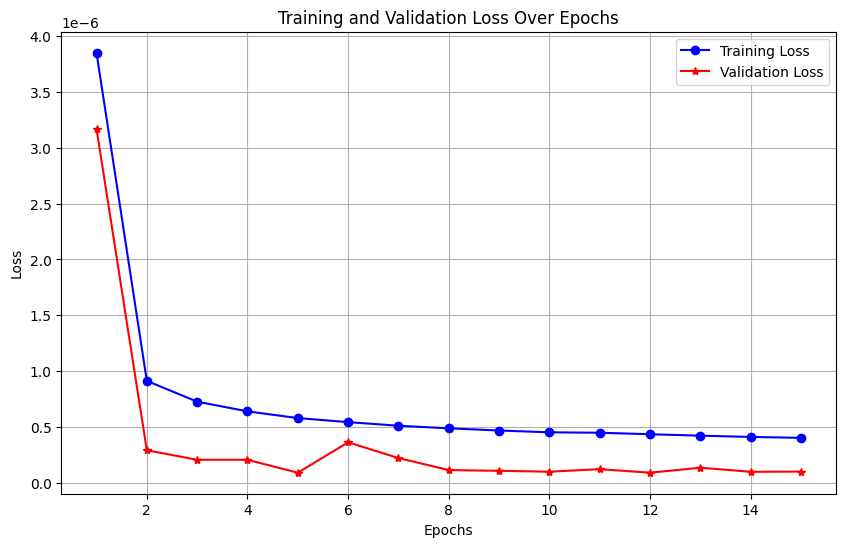

In [13]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# save the model
model.save('BTCUSDT.keras')

In [45]:
# Every minute for the date of 01-03-2024 we use the model to predict the mean next 5 closing prices.

# First we need to get the data for that date
df = pd.read_csv('StockData/BTCUSDT.csv')

def get_averages(data):

    # only take close and open
    data = data[['Open time','Close', 'Open']]

    data['MA5'] = data['Close'].rolling(window=5).mean()

    data['MA20'] = data['Close'].rolling(window=20).mean()

    data['MA60'] = data['Close'].rolling(window=60).mean()

    data['MA10080'] = data['Close'].rolling(window=10080).mean()

    # Drop if even one of the values is na
    # data = data.dropna()

    newdata = data[['Open time', 'Close', 'MA5', 'MA20', 'MA60', 'MA10080']]

    return newdata


In [54]:

def normalise_averages(averages):
    
    # For every column in the pd dataframe we normalise
    for i in averages.columns[1:]:
        averages[i] = (averages[i] - averages[i].min()) / (averages[i].max() - averages[i].min())

    return averages

testing = get_averages(df)

testing = normalise_averages(testing)
# only take the data from '2024-01-03'
# get '2024-01-03 in unix time
# assigned regular string date


from datetime import datetime
import time

# # Normalise the values

# testing = testing.dropna()
# testing = 


testing['datetime'] = pd.to_datetime(testing['Open time'], unit='ms') 

# # take only the date of '2024-01-03'

testing = testing[testing['datetime'].dt.date == datetime.strptime('2024-01-03', '%Y-%m-%d').date()]

# # Now test these values with the model

# # Get the last seq_length values

last_values = testing[['Close', 'MA5', 'MA20', 'MA60', 'MA10080']].values[-seq_length:]

# # Run the values through the model

last_values = last_values.reshape(1, seq_length, 5)

# # Predict the mean of the next 5 closing prices

last_values = model.predict(last_values)

print(last_values)






/tmp/ipykernel_10216/2879855496.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA5'] = data['Close'].rolling(window=5).mean()
/tmp/ipykernel_10216/2879855496.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA20'] = data['Close'].rolling(window=20).mean()
/tmp/ipykernel_10216/2879855496.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

[[0.60125108 0.60341201 0.60602269 0.60662421 0.64103057]
 [0.60230875 0.60348963 0.6059657  0.60656169 0.64102938]
 [0.60158107 0.60341865 0.60587351 0.60648785 0.64102812]
 [0.60149706 0.60335637 0.60577255 0.60641041 0.64102681]
 [0.60158893 0.60338766 0.60567892 0.6063368  0.64102549]
 [0.60138087 0.60341371 0.60559304 0.60625909 0.64102416]
 [0.60173791 0.60329915 0.60552887 0.60619268 0.64102288]
 [0.60207848 0.60339897 0.60548185 0.60613898 0.64102162]
 [0.60237629 0.60357541 0.60544003 0.60609539 0.64102048]
 [0.60244776 0.60374776 0.60539373 0.60604604 0.64101931]
 [0.60266141 0.60400474 0.60534101 0.60600467 0.64101822]
 [0.60287929 0.60423379 0.6053501  0.60597101 0.64101714]
 [0.60257679 0.60433379 0.6053652  0.6059517  0.64101605]
 [0.60246634 0.60435187 0.60539016 0.60592657 0.64101493]
 [0.60256607 0.60437561 0.60540854 0.60590532 0.64101385]
 [0.60347657 0.6045392  0.60547854 0.60588816 0.64101289]
 [0.60359186 0.60468219 0.60556259 0.60587713 0.64101191]
 [0.60379342 0